In [265]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib.pyplot as plt

#### Beginning thoughts

I looked through several options for model_iteration_2: DataQuest Mission 75, the blog posts of several other kaggle competition participants, and scanning the forums for ideas. Afer completing DataQuest Mission 75 in depth I think that it provides the most comprehensive starting point for model_iteration_2, and I really appreciate the opportunity to both read code and implement ideas (a rare opportunity since the titanic dataset in particular is an educational dataset?). Hopefully the work done in this notebook becomes a resource of examples for projects in the near future; the lambda functions passed into .apply and the regular expression usage in particular are not things that I use commonly in python. 

In this notebook I will explain and use the code that was suggested in DataQuest Mission 75, and adapt it to implement additional ideas. The markdown cells also include some reflection on the process and how I reacted to the dataquest mission. 

Overall Themes of DataQuest Mission 75:

* Use a better machine learning algorithm.
* Generate better features.
* Combine multiple machine learning algorithms.

#### Import the datasets

In [266]:
titanic = pandas.read_csv("./data/train.csv")
titanic_test = pandas.read_csv("./data/test.csv")

#### Clean up the training data (same as what we did in model_iteration_1)

In [267]:
# Replace the missing age values with the median age
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

# From genders to numbers
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

# From embarked letters to numbers
titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

#### Clean up the test data (same as what we did in model_iteration_1)

In [268]:
titanic_test = pandas.read_csv("./data/test.csv")

# Age column
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

# Sex column
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

# Embarked column
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

# Fare column
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].median())

#### Random forests!

Random forests have the ability to capture many different "layers" of relationships between the features in our dataset. I use the word "layers" here to loosely describe the different branches of decision trees in the random forest. Random forests are random because each decision tree in the forest gets a random subset of the data. Taking the average of the results from the trees will then result in the model's prediction. 

In [269]:
# Code from DataQuest mission 75

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default parameters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"])
print(scores.mean())

0.801346801347


This first stab with random forests resulted in 80% accuracy, which is better than the linear and logistic regression in model_iteration_1. Based on what I know about these three algorithms, I can see how random forests do a better job of capturing the complicated relationships between features in this dataset -- for example, the branches can capture how the same non-sex features can impact men and women differently.

A lot of people who use random forest models in their implementation are also a fan of visualizing a tree from their random forest, such as the picture included in [triangleinequality's tutorial](https://triangleinequality.wordpress.com/2013/09/05/a-complete-guide-to-getting-0-79903-in-kaggles-titanic-competition-with-python/) and shown immediately below. 

![a tree in the random forest](https://triangleinequality.files.wordpress.com/2013/09/sample_tree1.png?w=960&h=960)

The blue nodes are the leaves that represent whether that path of the tree resulted in survival or death. The dataquest mission also explained some of the relevant "high-level" parameters of the random forest model, such as the amount of splits and how many samples are needed to create a leaf (try tweaking `min_samples_split` and `min_samples_leaf`). There is probably a fair amount of iteration involved in finding the sweet spot of branches/layers of the decision tree (too many branches will result in overfitting on the training dataset, and too little branches will result in a ineffective set of decision trees). 

#### Making new features

Bulletpoints of suggestions from the dataquest page:
* The length of the name -- this could pertain to how rich the 
person was, and therefore their position in the Titanic.
* The total number of people in a family (SibSp + Parch).

Emily's commentary:   
* I'm not sure if the first bulletpoint would make a nontrivial improvement, since the wealth of the passengers could already be represented with the `Pclass` variable, and names have a ton of variation on their own. We can confirm this with a correlation coefficient or some other measure for relevance of a feature on the prediction.    
* I think the second bulletpoint would result in an improvement to the model. One potential story behind the family feature is that people with families stick together and help each other escape. Another potential story is that large families may have a tough time trying to get everyone safe because of all the craziness of the event and the many people they are trying to take care of at once. It also makes more sense to put family as one feature rather than `SibSp` and `Parch` separately if they both help the model "figure out the family situation" -- maybe the curse of dimensionality is showing up here.

In [270]:
# Code from DataQuest mission 75

# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

I usually don't use lambda functions in python, so I super appreciated the quick example above with the `.apply` method. I'll be sure to remember that when I'm working with dataframes in the future!

The dataquest mission used regular expressions to extract the titles from the names of the passengers -- this idea was also mentioned in the class discussion in Data Science last week. Similarly to the lambda used above, I also don't have a ton of experience with regular expressions, and appreciate this example! Definitely makes this notebook a valuable resource for future projects if I still need the examples in the near future.

In [271]:
# Code from DataQuest mission 75

import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


The dataquest mission dives deeper into the "family" storyline by making family groups. While this part of the dataquest mission didn't prompt me to write any additional code, I super appreciated the example of a working implementation to read through and understand at my own pace.

In [272]:
# Code from DataQuest mission 75

import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


#### Finding the best features

The mission provides an example of univariate feature selection -- figuring out which features are most relevant by calculating a "feature score" for each feature (column inn the dataframe).

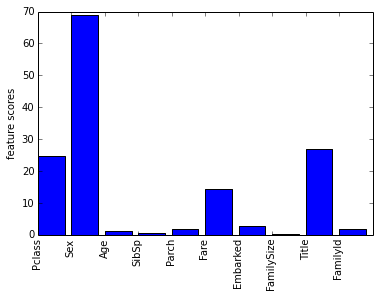

mean of the random forest scores 0.811447811448


In [273]:
# Code from DataQuest mission 75

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.ylabel("feature scores")

plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print "mean of the random forest scores", scores.mean()

#### gradient boosting and ensembling!

I had heard of gradient boosting in passing from ML enthusiast friends, but I hadn't tried it in person... at a high level, the dataquest page says that the errors from one tree will help the next tree learn the dataset more effectively. There are also some suggested parameters to prevennt overftting: limiting the tree count and tree depth. 

The dataquest then describes ensembling -- making predictions based on several different models and averaging their results to make a final decision on what the prediction is. My reaction: ensembling seems super useful! It sounds like ensembling presents the opportunity and challenge of balancing the strengths and weaknesses of many different models; it's another layer of algorithm design and ensemble parameter tweaking.

In [274]:
# Code from DataQuest Mission 75

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


#### Preparing and predicting on the test set

In [275]:
# Code from DataQuest Mission 75

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles

# Check the counts of each unique title.
# print(pandas.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
# print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

In [276]:
# Code from DataQuest Mission 75

predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

# turning the predictions into 0s and 1s
for i in range(predictions.shape[0]):
    predictions[i] = (predictions[i] >= 0.5)

predictions = predictions.astype(int)

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    }) 

In [277]:
# Save it
submission.to_csv("dataquest75.csv", index=False)

#### How the model performed on kaggle

The model had a score of 0.79904 and is at rank 1003 on the kaggle leaderboards. It is reassuring that the changes explored in the dataquest mission resulted in a nontrivial improvement on test performance over the logistic regression models from model_iteration_1! I have a feeling that Data Science projects are neverending -- there's always some room for improvement or new combination of ideas to try and see if those new ideas work just as well or better than the current iteration.

#### Ideas for future work

If I had more time...

* Getting more familiar with scikit learn and the many algorithms it has -- ensemble lots of things!
* Trying different ensembling techniques:
     * instead of averaging, maybe voting (going with what the majority of the models say),
     * the [wikipedia page on Ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) and the [scikit learn page on Ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html) -- maybe trying things like AdaBoost, the Bayes optimal classifier, etc. and plotting their performance vs. ensemble learning method
* Following advice from this scikit learn cheat-sheet on the [Choosing the right estimator](http://scikit-learn.org/stable/tutorial/machine_learning_map/) page (the image on the webpage also includes links for the boxes in this figure):
![scikit-learn algorithm cheat-sheet](http://scikit-learn.org/stable/_static/ml_map.png)
* Reading more about the history of the Titanic and getting more inspiration from the details of the event (gathering more domain-specific knowledge than I currently have about the Titanic) 
* Trying different numbers of folds for the experiments and plotting the model performance vs. number of folds. There must be a sweet spot between too many folds (too little training data for each sub-trial of the model to do well...) and too little folds.

#### Ending thoughts

In regards to time management... Week 2 of the semester definitely was a "recalibration" week for me -- I've found that I'm most productive in Data Science when I have at least 1.5 hours to work. Here's a quick bulletpoint list of the proces:

* gathering resources and figuring out which tools to try using first, 
* reading, 
* implementing code, 
* jotting down commentary in real time with the markdown cells
* debugging code, 
* learning about functionality of the tools (or perhaps investigating other tools)
* getting creative with ideas on how to improve the model, 
* implementing those creative ideas and debugging,
* continued...

There are so many steps that need to happen before one can easily do creative changes to improve your model! Definitely worth thinking about this process with the future steps in mind. e.g. Once the first pass at implementating the data cleanup, feature engineering, and training the model is done, make functions that can be used for speedy feature engineering and testing in the creative phase. Also, take advantage of how easy it is to swap scikit-learn functions. 

At the beginning of this warmup project I felt like each step could be a timesink and was overwhelmed by the amount of work goes into each notebook. I also felt like I could have done more at any step in time and tried to express these ideas in the markdown cells. I've done this process before in the machine learning co-curricular but that was with a smaller time commitment and longer timespan (1 credit for DoML vs. 4 credits for Data Science). In the future I'll do a better job of breaking down tasks into smaller chunks that I can do in my relatively frequent small chunks of free time (often I have 30-60 minutes free during the workday hours) and leaving notes to myself about where I left off. In retrospect this seems like common sense with Olin workload time management but this warmup project was a helpful "recalibration" phase for me before the next projects start. :) 

I definitely value the opportunity for creativity in the "improving your model" phase -- next time I will try some creative exercises to generate a large quantity of ideas, and how visualizations or results will either confirm those ideas or lead to new questions. In this project I didn't devote a lot of time to do divergent thinking exercises but will try refining the creative process in Data Science in the next projects.